## Stationarizing Tp- temperature

In [1]:
# load required modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss

In [2]:
df = pd.read_csv('imputedWQ.csv', parse_dates=True, header=0, index_col=0)
testset = pd.read_csv('../Data/testing2018-mean_imputed.csv', parse_dates=True, header=0, index_col=0)

In [3]:
df.describe()

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2
count,139566.000000,139566.000000,139566.000000,139566.000000,139566.000000,139566.000000,139566.000000,139566.000000,139566.000000
mean,8.515737,0.165479,8.366189,752.903321,209.528867,17.960881,98.847590,1535.536995,928.192685
std,1.279825,0.010169,0.101282,12.897289,7.719253,7.667370,27.260429,208.115945,147.029374
min,0.000000,0.000000,4.000000,300.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.500000,0.160000,8.340000,751.000000,209.000000,15.000000,102.000000,1390.000000,847.000000
50%,8.300000,0.170000,8.370000,754.000000,211.000000,17.000000,106.000000,1516.000000,927.000000
75%,9.500000,0.170000,8.390000,756.000000,211.000000,23.000000,109.000000,1653.000000,1000.000000
max,11.800000,0.800000,8.936228,895.000000,646.000000,254.000000,462.000000,3923.000000,2592.000000


In [4]:
# create Series object
Tp = df['Tp']
Cl = df['Cl']
pH = df['pH']
Redox = df['Redox']
Leit = df['Leit']
Trueb= df['Trueb']
Cl2 = df['Cl_2']
Fm = df['Fm']
Fm_2 = df['Fm_2']

In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries,name):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12*60).mean()
    rolstd  = timeseries.rolling(12*60).std() 
    plt.figure(figsize=(10,2))
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='aqua',label='Original',lw=2)
    std = plt.plot(rolstd, color='red', label = 'Rolling Std',lw=1.8)
    mean = plt.plot(rolmean, color='green', label='Rolling Mean', lw=1.2)
    
    plt.rcParams['xtick.labelsize'] = 9
    plt.rcParams['ytick.labelsize'] = 9

    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.savefig('../Images/img1.png', dpi=500, bbox_inches='tight')
    plt.savefig(name)
    plt.show
    plt.show(block=False)
    

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

### Making TP stationary- Differencing

In [6]:
tp_diff = Tp - Tp.shift()


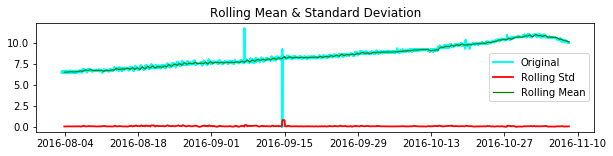

Results of Dickey-Fuller Test:
Test Statistic                     -1.369337
p-value                             0.596885
#Lags Used                         74.000000
Number of Observations Used    139491.000000
Critical Value (1%)                -3.430397
Critical Value (5%)                -2.861561
Critical Value (10%)               -2.566781
dtype: float64


In [7]:
#plt.figure(figsize=(10,2))
#plt.plot(Tp,color='red',lw=2)
#plt.plot(tp_diff,color='green',lw=0.9)

test_stationarity(Tp, 'tp-rm.png')

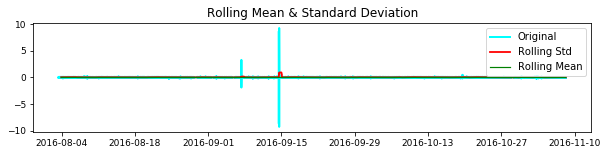

Results of Dickey-Fuller Test:
Test Statistic                    -52.802826
p-value                             0.000000
#Lags Used                         74.000000
Number of Observations Used    139490.000000
Critical Value (1%)                -3.430397
Critical Value (5%)                -2.861561
Critical Value (10%)               -2.566781
dtype: float64


In [9]:
tp_diff = tp_diff.iloc[1:]
test_stationarity(tp_diff, 'differencing.png')
#tp_diff.head(100).sum()

In [9]:
tp_diff.mean()

2.5794432701608567e-05

# Random forest classifier

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.feature_selection import SelectFromModel

In [19]:
dataset = pd.read_csv('../Data/imputedWQ.csv', parse_dates=True, header=0, index_col=0)
testset = pd.read_csv('../Data/testing2018-mean_imputed.csv', parse_dates=True, header=0, index_col=0)

In [20]:
X = dataset.drop('EVENT', axis=1)  
y = dataset['EVENT']  

In [22]:
X = X.drop('Tp', axis=1)
X.head(2)

,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2
Time,,,,,,,,
2016-08-03 09:49:00,0.17,8.36,749.0,211.0,11.0,118.0,1677.0,695.0
2016-08-03 09:50:00,0.17,8.36,749.0,211.0,11.0,118.0,1561.0,696.0


In [23]:
X = X.iloc[1:]
y= y.iloc[1:]
X.head(1)

,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2
Time,,,,,,,,
2016-08-03 09:50:00,0.17,8.36,749.0,211.0,11.0,118.0,1561.0,696.0


In [24]:
X = pd.concat([tp_diff, X], axis=1)

In [25]:
tss = TimeSeriesSplit(n_splits=4)
X.head(4)

,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2
Time,,,,,,,,,
2016-08-03 09:50:00,0.0,0.17,8.36,749.0,211.0,11.0,118.0,1561.0,696.0
2016-08-03 09:51:00,0.0,0.17,8.35,749.0,211.0,11.0,117.0,1581.0,696.0
2016-08-03 09:52:00,0.0,0.17,8.35,749.0,211.0,11.0,118.0,1579.0,693.0
2016-08-03 09:53:00,0.0,0.17,8.35,749.0,211.0,11.0,118.0,1567.0,689.0


In [26]:
scoring = ['f1', 'f1_macro', 'f1_micro', 'precision', 'recall']

In [53]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=4, n_estimators= 150, random_state=0)

results = cross_validate(rf_clf, X, y, cv=tss, scoring=scoring, n_jobs=-1)

/home/syka/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/syka/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/syka/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [30]:
print("Model(RF, 2): ({0}, {1}, {2}, {3},{4})\n".format(results['test_f1'].mean(),results['test_f1_micro'].mean() , results['test_f1_macro'].mean(), results['test_precision'].mean(), results['test_recall'].mean()))

Model(RF, 2): (0.4829275565715714, 0.9891537993049833, 0.7387003310543245, 0.5680769230769231,0.5050387820883255)



In [31]:
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': np.arange(2, 100, 10),
              'max_depth':np.arange(2,5)}

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=tss, scoring="f1_micro", n_jobs=-1)

In [32]:
grid.fit(X,y)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=4),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': array([ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92]), 'max_depth': array([2, 3, 4])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_micro', verbose=0)

In [33]:
grid.best_params_

{'max_depth': 3, 'n_estimators': 12}

In [34]:
model = grid.best_estimator_

In [35]:
results = cross_validate(model, X, y, cv=tss, scoring=scoring, n_jobs=-1)
print("Model(RF, 2): ({0}, {1}, {2}, {3},{4})\n".format(results['test_f1'].mean(),results['test_f1_micro'].mean() , results['test_f1_macro'].mean(), results['test_precision'].mean(), results['test_recall'].mean()))

Model(RF, 2): (0.5099311035837872, 0.9892523197076631, 0.7522266789764271, 0.604739010989011,0.5052819727498041)



## Test set

In [85]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=4, n_estimators= 300, random_state=0)

rf_clf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [120]:
Tp1 = testset['Tp']
tp_diff = Tp1 - Tp1.shift()
tp_diff = tp_diff.iloc[1:]
X_test = X_test.drop('Tp', axis=1)
X_test = X_test.iloc[1:]
y_test= y_test.iloc[1:]
X_test.head(1)
X_test = pd.concat([tp_diff, X_test], axis=1)

In [36]:
X_test = testset.drop('EVENT', axis=1)  
y_test = testset['EVENT']  

In [86]:
predicted = rf_clf.predict(X_test)

In [87]:
f1_score(y_test,predicted)

0.48035450516986694

In [88]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,predicted)

array([[115393,    243],
       [  1516,    813]])

In [89]:
print(f1_score(y_test,predicted))
print(recall_score(y_test,predicted))
print(precision_score(y_test,predicted))

0.48035450516986694
0.3490768570201803
0.7698863636363636
